In [1]:
import torch
from refactor.probes import model_setup

In [2]:
model_names = ["gpt_gptsw3_en_da_356m_gbs1024","gpt_gptsw3_en_da_is_356m_gbs1024","gpt_gptsw3_en_is_da_356m_gbs1024","gpt_sw3_356m"]
lambda_val = 5
layer = "transformer.h.15.ln_1.bias"
for model_name in model_names:
    
    model_path = "downloaded_models/"

    model, tokenizer, device = model_setup(f"{model_path}{model_name}")
    
    steering = torch.load(f"steering_vectors/{model_name}/combined_steering_vector_layer_15_tensor.pt",map_location = device)
    
    model.state_dict()[layer] += steering*lambda_val
    
    model.save_pretrained(f'{model_path}/{model_name}_with_steering_lambda_{lambda_val}')
    tokenizer.save_pretrained(f'{model_path}/{model_name}_with_steering_lambda_{lambda_val}')  # Optional but recommended

found device: cpu


/var/folders/p0/267bnxr16cq2xpr1crtpxbgw0000gn/T/ipykernel_4552/1524319005.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  steering = torch.load(f"steering_vectors/{mod

found device: cpu


/var/folders/p0/267bnxr16cq2xpr1crtpxbgw0000gn/T/ipykernel_4552/1524319005.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  steering = torch.load(f"steering_vectors/{mod

found device: cpu


/var/folders/p0/267bnxr16cq2xpr1crtpxbgw0000gn/T/ipykernel_4552/1524319005.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  steering = torch.load(f"steering_vectors/{mod

found device: cpu


/var/folders/p0/267bnxr16cq2xpr1crtpxbgw0000gn/T/ipykernel_4552/1524319005.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  steering = torch.load(f"steering_vectors/{mod

In [ ]:
from refactor.probes import model_setup
import os
from scipy.spatial.distance import euclidean, mahalanobis, cosine
from sklearn.metrics.pairwise import cosine_similarity
import torch
from refactor.utils.hooking import HookManager
from refactor.utils.compatibility import HookAddress
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as patches





    
       

In [2]:
from refactor.probes import model_setup
import os
from scipy.spatial.distance import euclidean, mahalanobis, cosine
from sklearn.metrics.pairwise import cosine_similarity
import torch
from refactor.utils.hooking import HookManager
from refactor.utils.compatibility import HookAddress
import pickle
# loads model
print("Load model") 
model_name = "EleutherAI/pythia-14m"
model_name = "AI-Sweden-Models/gpt-sw3-356m"
#model, tokenizer, device = model_setup(model_name)
model_name_temp = "gpt_sw3_356m"


Load model


In [3]:
with open(f'results/data/neuron_contributions/{model_name_temp}.pkl', 'rb') as f:
    neuron_contributions = pickle.load(f)

In [ ]:
from matplotlib import pyplot as plt


array([ 94.50209 ,  20.787539,  97.373344, ...,  95.90053 , 107.91054 ,
       100.78639 ], dtype=float32)

(array([  9., 808., 185.,  14.,   5.,   0.,   1.,   1.,   0.,   1.]),
 array([ 30.21384048,  52.52946472,  74.84508514,  97.1607132 ,
        119.47633362, 141.79196167, 164.10757446, 186.42320251,
        208.73883057, 231.05444336, 253.37007141]),
 <BarContainer object of 10 artists>)

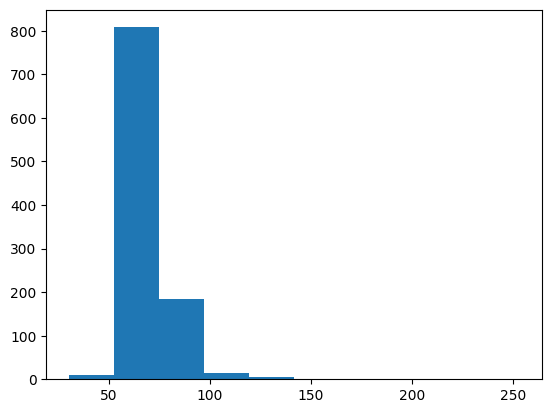

In [11]:
plt.hist(neuron_contributions[(3,"attention-post")])